# Preparation

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [23]:
import STAGATE

In [24]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
input_dir = 'Data/Tutorial2'

In [25]:
adata = sc.read_visium(path=input_dir, count_file='V1_Adult_Mouse_Brain_Coronal_Section_1_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [26]:
adata

AnnData object with n_obs × n_vars = 2903 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [27]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

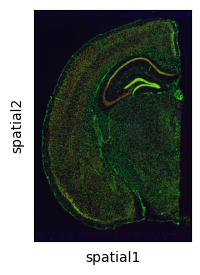

In [28]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires")

------Calculating spatial graph...
The graph contains 16982 edges, 2903 cells.
5.8498 neighbors per cell on average.


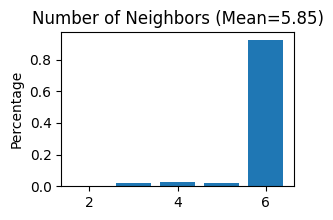

In [29]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=300)
STAGATE.Stats_Spatial_Net(adata)

In [30]:
adata = STAGATE.train_STAGATE(adata, alpha=0.5, pre_resolution=0.2,
                              n_epochs=1000, save_attention=True)

Size of Input:  (2903, 3000)


2023-10-19 13:51:12.581089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:4f:00.0
2023-10-19 13:51:12.581226: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory
2023-10-19 13:51:12.581271: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shared object file: No such file or directory
2023-10-19 13:51:12.581309: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcufft.so.10.0'; dlerror: libcufft.so.10.0: cannot open shared object file: No such file or directory
2023-10-19 13:51:12.581349: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Cou

------Pre-clustering using louvain with resolution=0.20
------Pruning the graph...
16982 edges before pruning.
15058 edges after pruning.


100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]


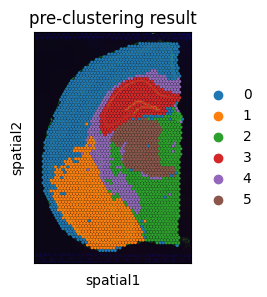

In [31]:
# pre-clustering result
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color="expression_louvain_label", size=1.5, title='pre-clustering result')

In [32]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=1)

In [33]:
adata.uns['louvain_colors']=['#aec7e8', '#9edae5', '#d62728', '#dbdb8d', '#ff9896',
                             '#8c564b', '#696969', '#778899', '#17becf', '#ffbb78',
                             '#e377c2', '#98df8a', '#aa40fc', '#c5b0d5', '#c49c94',
                             '#f7b6d2', '#279e68', '#b5bd61', '#ad494a', '#8c6d31',
                             '#1f77b4', '#ff7f0e']

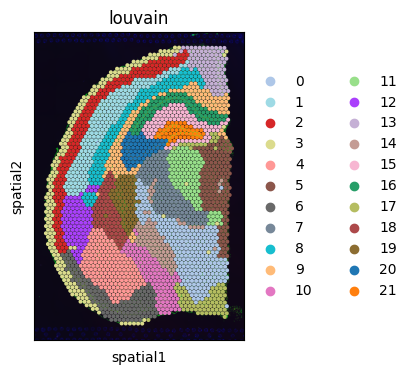

In [34]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata, img_key="hires", color="louvain", size=1.5)

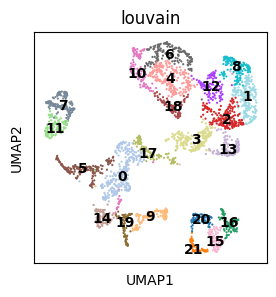

In [35]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color="louvain", legend_loc='on data', s=10)

# Visualization of the attention layer

In [36]:
import matplotlib as mpl
import networkx as nx

In [37]:
att_df = pd.DataFrame(adata.uns['STAGATE_attention'][0].toarray(), index=adata.obs_names, columns=adata.obs_names)
att_df = att_df.values
for it in range(att_df.shape[0]):
    att_df[it, it] = 0

In [38]:
G_atten = nx.from_numpy_matrix(att_df)
M = G_atten.number_of_edges()
edge_colors = range(2, M + 2)

In [39]:
coor_df = pd.DataFrame(adata.obsm['spatial'].copy(), index=adata.obs_names)
coor_df[1] = -1 * coor_df[1]
image_pos = dict(zip(range(coor_df.shape[0]), [np.array(coor_df.iloc[it,]) for it in range(coor_df.shape[0])]))

In [40]:
labels = nx.get_edge_attributes(G_atten,'weight')

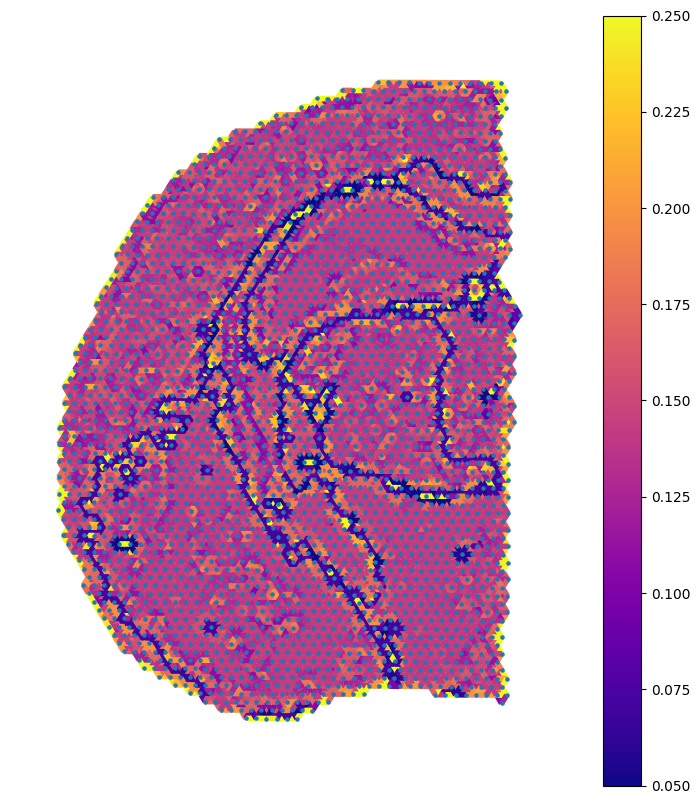

In [41]:
fig, ax = plt.subplots(figsize=[9,10])
nx.draw_networkx_nodes(G_atten, image_pos, node_size=5, ax=ax)
cmap = plt.cm.plasma
edges = nx.draw_networkx_edges(G_atten, image_pos, edge_color=labels.values(),width=4, ax=ax,
                               edge_cmap=cmap,edge_vmax=0.25,edge_vmin=0.05)
ax = plt.gca()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0.05, vmax=0.25))
sm._A = []
plt.colorbar(sm)

ax.set_axis_off()

# Running STAGATE without cell type-aware module (for comparison)

In [42]:
adata = STAGATE.train_STAGATE(adata, alpha=0, n_epochs=1000, save_attention=True)

Size of Input:  (2903, 3000)


2023-10-19 13:53:45.182313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:4f:00.0
2023-10-19 13:53:45.182471: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory
2023-10-19 13:53:45.182519: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shared object file: No such file or directory
2023-10-19 13:53:45.182564: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcufft.so.10.0'; dlerror: libcufft.so.10.0: cannot open shared object file: No such file or directory
2023-10-19 13:53:45.182604: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Cou

In [43]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=1)

In [44]:
adata.uns['louvain_colors']=['#aec7e8', '#9edae5', '#d62728', '#dbdb8d', '#ff9896',
                             '#8c564b', '#696969', '#778899', '#17becf', '#ffbb78',
                             '#e377c2', '#98df8a', '#aa40fc', '#c5b0d5', '#c49c94',
                             '#f7b6d2', '#279e68', '#b5bd61', '#ad494a', '#8c6d31',
                             '#1f77b4', '#ff7f0e']

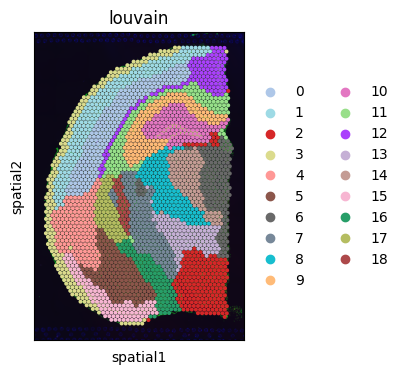

In [45]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata, img_key="hires", color="louvain", size=1.5)

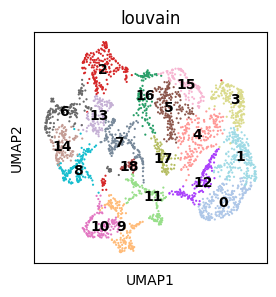

In [46]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color="louvain", legend_loc='on data', s=10)

# Visualization of the attention layer (without cell type-aware module)

In [47]:
att_df = pd.DataFrame(adata.uns['STAGATE_attention'][0].toarray(), index=adata.obs_names, columns=adata.obs_names)
att_df = att_df.values
for it in range(att_df.shape[0]):
    att_df[it, it] = 0

In [48]:
G_atten = nx.from_numpy_matrix(att_df)
M = G_atten.number_of_edges()
edge_colors = range(2, M + 2)

In [49]:
coor_df = pd.DataFrame(adata.obsm['spatial'].copy(), index=adata.obs_names)
coor_df[1] = -1 * coor_df[1]
image_pos = dict(zip(range(coor_df.shape[0]), [np.array(coor_df.iloc[it,]) for it in range(coor_df.shape[0])]))

In [50]:
labels = nx.get_edge_attributes(G_atten,'weight')

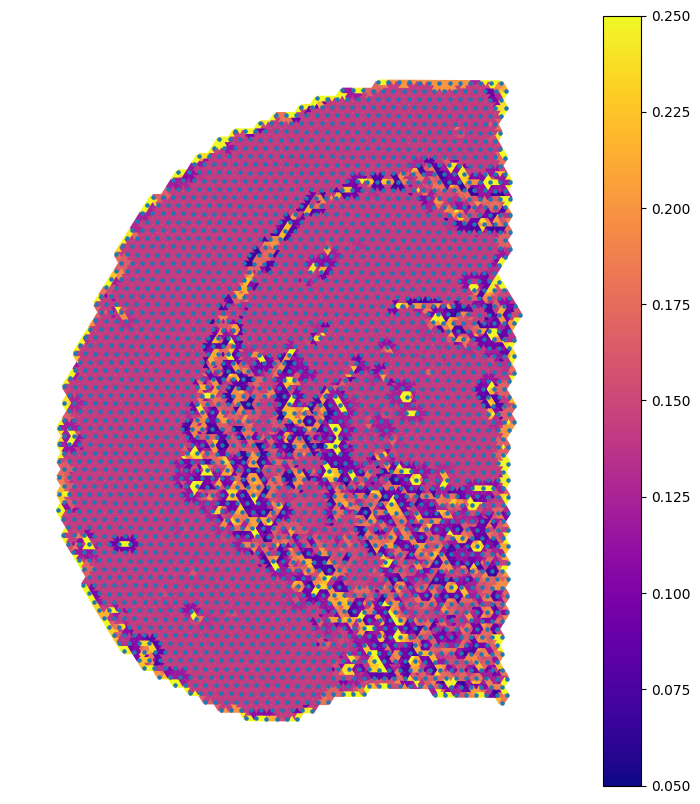

In [51]:
fig, ax = plt.subplots(figsize=[9,10])
nx.draw_networkx_nodes(G_atten, image_pos, node_size=5, ax=ax)
cmap = plt.cm.plasma
edges = nx.draw_networkx_edges(G_atten, image_pos, edge_color=labels.values(),width=4, ax=ax,
                               edge_cmap=cmap,edge_vmax=0.25,edge_vmin=0.05)
ax = plt.gca()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0.05, vmax=0.25))
sm._A = []
plt.colorbar(sm)

ax.set_axis_off()
